In [1]:
import os
data_dir = '/home/tangli/Documents/deeplearningbook/deeplearningwithpython/data'
fname = os.path.join(data_dir,'jena_climate_2009_2016.csv')

In [2]:
f = open(fname)
data = f.read()
f.close()

In [3]:
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [4]:
lines[0]

'01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30'

In [5]:
# import numpy as np
# float_data = np.zeros((len(lines), len(header) - 1))
# for i, line in enumerate(lines):
#     values = [float(x) for x in line.split(',')[1:]]
#     float_data[i, :] = values
    
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values    

In [6]:
from matplotlib import pyplot as plt
temp = float_data[:, 1] 
plt.plot(range(len(temp)), temp)
plt.show()

# from matplotlib import pyplot as plt

# temp = float_data[:, 1]  # temperature (in degrees Celsius)
# plt.plot(range(len(temp)), temp)
# plt.show()

<Figure size 640x480 with 1 Axes>

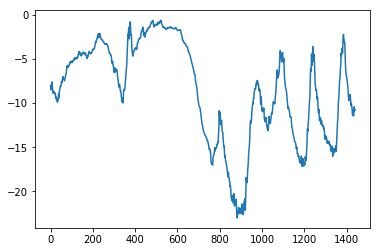

In [7]:
plt.plot(range(1440), temp[:1440])
plt.show()


In [8]:
# normalizing the data
# mean = float_data[:200000].mean(axis=0)
# float_data -=mean
# std = float_data[:200000].std(axis=0)
# float_data /= std

mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [9]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, 
                                     max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [10]:
lookback=1440
step =6
delay=144
batch_size = 128

In [11]:
train_gen = generator(float_data, lookback=lookback,
                     delay=delay, min_index=0,
                     max_index=200000, shuffle=True,
                     step = step, batch_size=batch_size)

In [12]:
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)

In [13]:
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

In [14]:
val_steps = (300000 - 200001 - lookback) // batch_size

In [15]:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [16]:
np.mean(np.abs(preds - targets))

NameError: name 'preds' is not defined

In [17]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds=samples[:,-1,1]
        mae = np.mean(np.abs(preds-targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback//step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

In [ ]:
model.compile(optimizer=RMSprop(), loss='mae')

In [ ]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

In [18]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Using TensorFlow backend.


Epoch 1/20
500/500 [==============================] - 100s 200ms/step - loss: 0.2990 - val_loss: 0.2734
Epoch 2/20
500/500 [==============================] - 96s 191ms/step - loss: 0.2829 - val_loss: 0.2683
Epoch 3/20
500/500 [==============================] - 94s 188ms/step - loss: 0.2768 - val_loss: 0.2621
Epoch 4/20
500/500 [==============================] - 94s 187ms/step - loss: 0.2725 - val_loss: 0.2652
Epoch 5/20
500/500 [==============================] - 94s 187ms/step - loss: 0.2652 - val_loss: 0.2669
Epoch 6/20
500/500 [==============================] - 94s 188ms/step - loss: 0.2612 - val_loss: 0.2644
Epoch 7/20
500/500 [==============================] - 94s 189ms/step - loss: 0.2568 - val_loss: 0.2645
Epoch 8/20
500/500 [==============================] - 94s 188ms/step - loss: 0.2528 - val_loss: 0.2710
Epoch 9/20
500/500 [==============================] - 94s 189ms/step - loss: 0.2477 - val_loss: 0.2772
Epoch 10/20
500/500 [==============================] - 94s 189ms/step - 

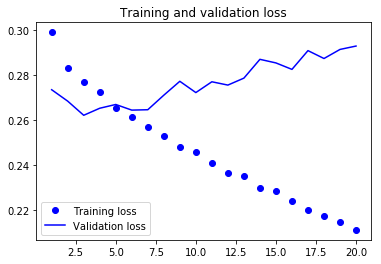

In [19]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 107s 214ms/step - loss: 0.3335 - val_loss: 0.2731
Epoch 2/40
500/500 [==============================] - 106s 213ms/step - loss: 0.3150 - val_loss: 0.2706
Epoch 3/40
500/500 [==============================] - 106s 213ms/step - loss: 0.3077 - val_loss: 0.2678
Epoch 4/40
500/500 [==============================] - 106s 213ms/step - loss: 0.3032 - val_loss: 0.2677
Epoch 5/40
156/500 [========>.....................] - ETA: 53s - loss: 0.2992

In [ ]:
float_data.shape